# Creating the Boundary Conditions

This notebook serves as a demo for the creation of model boundary conditions. These boundary conditions are shown for Lauren's Upwelling regional model. You can follow and/or adapt this notebook based on your configuration if you are using a regional domain.

First, import packages to re-create and visualize the model fields here:

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import netCDF4 as nc4
from eccoseas.downscale import vertical
import pandas as pd


Next, define the location of the input directory for the model. This is the same directory that holds the bathymetry file generated in the previous notebooks for this model example.

In [23]:
# define the input directory
input_dir = os.getcwd()

## Constructing the Boundary Conditions
For my model, I will use a model state from the ECCO Version 5 state estimate. I will prepare the boundary condition fields in 7 steps:
1. download 5 fields and 4 grid files generated by the ECCO model in 2008
2. read the ECCO model grid
3. read in the bathymetry for my model as well as its grid
4. prepare the ECCO fields for interpolation
5. interpolate the ECCO fields onto my model grid and store each as a binary file
6. plot the interpolated fields to ensure they look as expected
7. prepare notes on the run-time options I will use to implement my approach

### Step 1: Download the ECCO fields
To begin, I downloaded the model fields generated by the ECCO Version 4 Alpha state estimate. These fields are available [HERE](https://podaac.jpl.nasa.gov/ECCO?tab=mission-objectives&sections=about%2Bdata). In particular, I downloaded the following list of files that contain the field pertaining to my model (2008):

| Variable(s) | Location |
| -------- | --------- |
|THETA and SALT|[2008](https://cmr.earthdata.nasa.gov/virtual-directory/collections/C1991543728-POCLOUD/temporal/2008)|
|UVEL and VVEL|[2008](https://cmr.earthdata.nasa.gov/virtual-directory/collections/C1991543728-POCLOUD/temporal/2008/12)|

I also store the year as a variable:

In [24]:
year = 2008

I stored these fields in the same directory as this notebook:

In [25]:
# define the input directory
input_dir = os.getcwd()
data_folder = os.getcwd()
data_folder = '/Users/mike/Documents/MLML/MS 274/Lectures/Week 9/ECCO'

### Step 2: Read in the ECCO grid
To read in the ECCO fields, I will rely on the `grid` module from the `eccoseas.ecco` package [HERE](https://github.com/mhwood/eccoseas), which I import here:

In [26]:
from eccoseas.ecco import grid

In [27]:
ds = nc4.Dataset(os.path.join('GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc'))
ecco_XC_tiles = ds.variables['XC'][:,:,:]
ecco_YC_tiles = ds.variables['YC'][:,:,:]
ecco_hFacC_tiles = ds.variables['hFacC'][:,:,:,:]
ecco_hFacS_tiles = ds.variables['hFacS'][:,:,:,:]
ecco_hFacW_tiles = ds.variables['hFacW'][:,:,:,:]
ecco_RF_tiles = ds.variables['Z'][:]
ecco_DRF = ds.variables['drF'][:]

ds.close()

In [28]:
#Read in cruise CSV
Si_cruise = pd.read_csv('Si_cruise.csv')

Si_data = Si_cruise.rename(columns={
    'Depth [m]': 'Depth',
    'Silicate [mmol/kg]': 'Silicate'
})

Si_data = (
    Si_data
    .dropna(subset=['Depth', 'Silicate'])
    .astype({'Depth': float, 'Silicate': float})
    .sort_values('Depth')
)

#Interpolate onto ECCO vertical grid
z_data = Si_data['Depth'].to_numpy()
si_data = Si_data['Silicate'].to_numpy()

# ECCO RF are negative depths (m); flip sign so both are positive-down
z_model = -ecco_RF_tiles  # 1D array of depths in meters

Si_profile = np.interp(z_model, z_data, si_data, left=si_data[0], right=si_data[-1])

As described [HERE](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Plotting_Tiles.html), the ECCO grid has 13 tiles but only 1 or 2 may pertain to my local area. To determine which tiles correspond to my region, I'll read in my model grid next.

### Step 3: Read in the Model Grid and Generate a Mask
Here, I will recreate the grid I will use in my model and read in the bathymetry file (see previous notebooks for details):

In [29]:
# define the parameters that will be used in the data file
delX = 1/625
delY = 19/10000
xgOrigin = -122.2635
ygOrigin = 36.5436
n_rows = 245
n_cols = 300

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

# read in the bathymetry file
bathy = np.fromfile(os.path.join(input_dir,'bathymetry.bin'),'>f4').reshape(np.shape(XC))

With an eye toward the interpolation to come next, I will make a mask to determine where the interpolatation will take place. I will create this mask by recreating the `hFac` field for my model using the `hFac` module from the `eccoseas` package: 

In [30]:
from eccoseas.downscale import hFac

In [31]:
depth = bathy
delR = np.array([ 1.00,    1.14,    1.30,    1.49,   1.70,
                  1.93,    2.20,    2.50,    2.84,   3.21,
                  3.63,    4.10,    4.61,    5.18,   5.79,
                  6.47,    7.20,    7.98,    8.83,   9.73,
                 10.69,   11.70,   12.76,   13.87,  15.03,
                 16.22,   17.45,   18.70,   19.97,  21.27,
                 22.56,   23.87,   25.17,   26.46,  27.74,
                 29.00,   30.24,   31.45,   32.65,  33.82,
                 34.97,   36.09,   37.20,   38.29,  39.37,
                 40.45,   41.53,   42.62,   43.73,  44.87,
                 46.05,   47.28,   48.56,   49.93,  51.38,
                 52.93,   54.61,   56.42,   58.38,  60.53,
                 62.87,   65.43,   68.24,   71.33,  74.73,
                 78.47,   82.61,   87.17,   92.21,  97.79,
                103.96,  110.79,  118.35,  126.73, 136.01,
                146.30,  157.71,  170.35,  184.37, 199.89,
                217.09,  236.13,  257.21,  280.50, 306.24,
                334.64,  365.93,  400.38,  438.23, 479.74,])
Z = np.cumsum(delR)
hFacC = hFac.create_hFacC_grid(depth, delR)

The mask is generated by setting all of the non-zero `hFac` points to 1:

In [32]:
mask = np.copy(hFacC)
mask[mask>0] = 1

To double check the mask was created as expected, I will plot it in comparison to the bathymetry here:

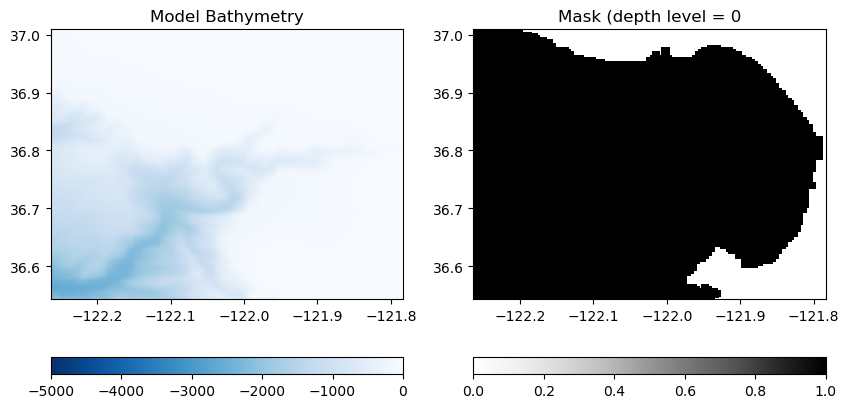

In [33]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

Seems reasonable!

### Step 4: Prepare the grids for interpolation
At this point, we can use the geometry of both grids to check to see which tiles have the information we need. After some trial and error (and referencing the ECCO page), I find that tiles 7 and 10 have the points I need:

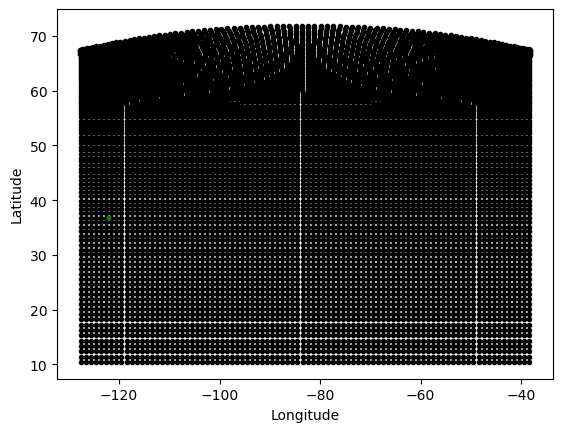

In [34]:
# plot the ECCO tile points from tiles 7 and 10
plt.plot(ecco_XC_tiles[10],ecco_YC_tiles[10],'k.')

# plot the boundary of the CA model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As we can see, my model boundary (green) is completely surrounded by the points in tile 8 and 11 (black). I also note that there is extraneous information in points with longitude greater than ~140 - I will omit these points as well. Given these observations, now I read in points from just those tiles to use in interpolation:

In [35]:
tile_list = [10]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_maskC_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_maskS_points = np.zeros((np.size(ecco_RF_tiles) , total_points))
ecco_maskW_points = np.zeros((np.size(ecco_RF_tiles) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles)):
        level_hFacC = ecco_hFacC_tiles[k, tile_number, :, :]
        level_hFacW = ecco_hFacW_tiles[k, tile_number, :, :]
        level_hFacS = ecco_hFacS_tiles[k, tile_number, :, :]
        level_mask_C = np.copy(level_hFacC)
        level_mask_C[level_mask_C>0] = 1
        level_mask_W = np.copy(level_hFacW)
        level_mask_W[level_mask_W>0] = 1
        level_mask_S = np.copy(level_hFacS)
        level_mask_S[level_mask_S>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        ecco_maskC_points[k,points_counted:points_counted+tile_N] = level_mask_C.ravel()
        ecco_maskW_points[k,points_counted:points_counted+tile_N] = level_mask_W.ravel()
        ecco_maskS_points[k,points_counted:points_counted+tile_N] = level_mask_S.ravel()
    
    points_counted += tile_N

# remove the points with positive longitude
local_indices = ecco_XC_points<0
ecco_maskC_points = ecco_maskC_points[:, local_indices]
ecco_maskS_points = ecco_maskS_points[:, local_indices]
ecco_maskW_points = ecco_maskW_points[:, local_indices]
ecco_hFacC_points = ecco_hFacC_points[:, local_indices]
ecco_hFacW_points = ecco_hFacW_points[:, local_indices]
ecco_hFacS_points = ecco_hFacS_points[:, local_indices]
ecco_YC_points = ecco_YC_points[local_indices]
ecco_XC_points = ecco_XC_points[local_indices]

Next, we'll read in the real data fields and apply the modifications. First, create a dictionary to store the file names:

In [38]:
# --- SILICATE FROM CRUISE DATA ONLY ---

timesteps = 12  # monthly climatology (or whatever you need)

# Read in cruise CSV
Si_cruise = pd.read_csv('Si_cruise.csv')

Si_data = Si_cruise.rename(columns={
    'Depth [m]': 'Depth',
    'Silicate [mmol/kg]': 'Silicate'
})

Si_data = (
    Si_data
    .dropna(subset=['Depth', 'Silicate'])
    .astype({'Depth': float, 'Silicate': float})
    .sort_values('Depth')
)

# Interpolate onto your model's vertical cell-center depths
z_data = Si_data['Depth'].to_numpy()       # positive-down
si_data = Si_data['Silicate'].to_numpy()

# Z is cumulative thickness (cell faces). Get approximate cell centers:
z_model = Z - 0.5 * delR                   # positive-down cell-center depths, same length as delR

Si_profile = np.interp(
    z_model, z_data, si_data,
    left=si_data[0], right=si_data[-1]
)   # shape (nz,)

# Repeat the vertical profile over all tiles/points,
# then restrict to local (negative longitude) points
Nz = len(delR)
N_tile = ecco_XC_tiles[tile_list[0]].size   # 90*90, but this is safer

Si_2D_alltiles = np.repeat(Si_profile[:, None], N_tile * len(tile_list), axis=1)  # (Nz, N_all)
Si_2D_local = Si_2D_alltiles[:, local_indices]                                   # (Nz, N_local)

# Give it a time dimension: constant in time for all 12 months
Si_BC_grids = np.repeat(Si_2D_local[None, :, :], timesteps, axis=0)
# shape: (timesteps, Nz (=len(delR)), N_local)


Now, read the fields from the same tiles:

In [40]:
# define the boundary list for the model
boundary_list = ['west', 'south', 'north']

if 'obcs' not in os.listdir(input_dir):
    os.mkdir(os.path.join(input_dir, 'obcs'))

from eccoseas.downscale import horizontal

# loop through each boundary
for boundary in boundary_list:
    print(' - Creating conditions on the ' + str(boundary) + ' boundary')

    if boundary == 'west':
        boundary_XC   = XC[:, :1]
        boundary_YC   = YC[:, :1]
        boundary_mask = mask[:, :, :1]
    elif boundary == 'east':
        boundary_XC   = XC[:, -1:]
        boundary_YC   = YC[:, -1:]
        boundary_mask = mask[:, :, -1:]
    elif boundary == 'north':
        boundary_XC   = XC[-1:, :]
        boundary_YC   = YC[-1:, :]
        boundary_mask = mask[:, -1:, :]
    elif boundary == 'south':
        boundary_XC   = XC[:1, :]
        boundary_YC   = YC[:1, :]
        boundary_mask = mask[:, :1, :]
    else:
        raise ValueError('Boundary ' + boundary + ' not recognized')

    # ----- SILICATE ONLY -----
    variable_name = 'SILICATE'      # change to 'TRAC01' or whatever your model expects

    # Silicate is a tracer at cell centers
    ecco_mask_points = ecco_maskC_points

    # mask out nonsense points (if any)
    Si_BC_grids[Si_BC_grids > 100] = 0

    # output grid: (time, vertical, boundary points)
    output_grid = np.zeros((timesteps, np.size(delR), np.size(boundary_XC)))

    print('    - Interpolating the ' + variable_name + ' grid')

    for t in range(timesteps):
        print('       - Timestep:', t)

        interpolated_grid = horizontal.downscale_3D_points(
            np.column_stack([ecco_XC_points, ecco_YC_points]),
            Si_BC_grids[t, :, :],      # (Nz, N_local)
            ecco_mask_points,
            boundary_XC,
            boundary_YC,
            boundary_mask
        )

        for k in range(len(delR)):
            output_grid[t, k, :] = interpolated_grid[k, :, :].ravel()

    # output the interpolated grid for this boundary
    output_file = os.path.join(input_dir, 'obcs',
                               f'{variable_name}_{boundary}_{year}')
    output_grid.ravel('C').astype('>f4').tofile(output_file)


 - Creating conditions on the west boundary
    - Interpolating the SILICATE grid
       - Timestep: 0


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


       - Timestep: 1
       - Timestep: 2
       - Timestep: 3
       - Timestep: 4
       - Timestep: 5
       - Timestep: 6
       - Timestep: 7
       - Timestep: 8
       - Timestep: 9
       - Timestep: 10
       - Timestep: 11
 - Creating conditions on the south boundary
    - Interpolating the SILICATE grid
       - Timestep: 0
       - Timestep: 1
       - Timestep: 2
       - Timestep: 3
       - Timestep: 4
       - Timestep: 5
       - Timestep: 6
       - Timestep: 7
       - Timestep: 8
       - Timestep: 9
       - Timestep: 10
       - Timestep: 11
 - Creating conditions on the north boundary
    - Interpolating the SILICATE grid
       - Timestep: 0
       - Timestep: 1
       - Timestep: 2
       - Timestep: 3
       - Timestep: 4
       - Timestep: 5
       - Timestep: 6
       - Timestep: 7
       - Timestep: 8
       - Timestep: 9
       - Timestep: 10
       - Timestep: 11


### Step 6: Plotting the Boundary Fields
Now that the fields have been generated, I will plot them to ensure they look as expected. First, I'll generate some metadata for each one:

In [21]:
meta_dict = {'THETA':[6, 18, 'turbo', 'm'],
            'SALT':[32, 35, 'viridis', 'm'],
            'UVEL':[-0.1, 0.1, 'seismic', 'm'],
            'VVEL':[-0.1, 0.1, 'seismic', 'm']}

Then, I'll create all of the subplots:

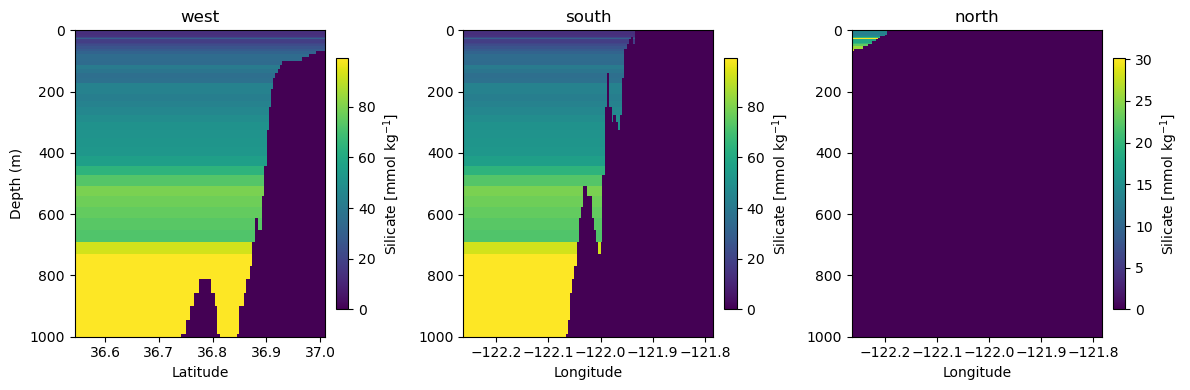

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Silicate boundary plots ---

variable_name = 'SILICATE'   # or 'TRAC01' if that's what you used in the filenames

fig = plt.figure(figsize=(12, 4))

plot_counter = 0

for boundary in boundary_list:
    
    # read in the Silicate OBC file for this boundary
    fname = os.path.join(input_dir, 'obcs', f'{variable_name}_{boundary}_{year}')
    Si_boundary = np.fromfile(fname, '>f4')
    
    # reshape depending on boundary orientation
    if boundary in ['west', 'east']:
        # (time, z, y)
        Si_boundary = Si_boundary.reshape((timesteps, len(delR), XC.shape[0]))
        Si_boundary = Si_boundary[0, :, :]  # first timestep
        if boundary == 'west':
            x = YC[:, 0]    # latitude along western boundary
        else:  # 'east'
            x = YC[:, -1]   # latitude along eastern boundary
        x_label = 'Latitude'
    else:
        # 'north' or 'south': (time, z, x)
        Si_boundary = Si_boundary.reshape((timesteps, len(delR), XC.shape[1]))
        Si_boundary = Si_boundary[0, :, :]  # first timestep
        if boundary == 'north':
            x = XC[-1, :]   # longitude along northern boundary
        else:  # 'south'
            x = XC[0, :]    # longitude along southern boundary
        x_label = 'Longitude'
    
    plot_counter += 1
    plt.subplot(1, len(boundary_list), plot_counter)
    
    # choose color limits based on data range, or hard-code if you prefer
    vmin = np.nanmin(Si_boundary)
    vmax = np.nanmax(Si_boundary)
    
    C = plt.pcolormesh(x, Z, Si_boundary,
                       vmin=vmin, vmax=vmax,
                       shading='auto')
    plt.colorbar(C, fraction=0.046, pad=0.04,
                 label='Silicate [mmol kg$^{-1}$]')
    
    plt.ylim([0, 1000])
    plt.gca().invert_yaxis()
    
    if plot_counter == 1:
        plt.ylabel('Depth (m)')
    plt.xlabel(x_label)
    plt.title(boundary)

plt.tight_layout()
plt.show()


Looks good! Now, with the initial conditions, external forcing conditions, and boundary conditions we are nearly ready to start testing the model!

### Step 7: Run-time considerations
To use the grids as boundary conditions in the model, I will use the `obcs` package - short for Open Boundary Condtions. To ensure the boundary conditions are included in the model, I will add a line for `obcs` in my `code/packages.conf` compile time file.

Next, I will add a line with ` useOBCS=.TRUE.` to the `data.pkg` file and a new file called `data.obcs` to my run directory. See Canvas for an editable `data.obcs` file.